# Session 4 — Paragraph-Level Analysis
## Measure 1: Paragraph Semantic Coherence

In this notebook, you will:
- split your text into paragraphs and sentences
- compute **embedding-based coherence** per paragraph using MiniLM
- compare coherence distributions across two books
- connect this to how RAG systems and LLMs assess chunk quality

We again use Lewis Carroll's *Alice* books as examples. Replace the file
paths with your own author/text for your project.


In [1]:
import re
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import gc

# Initialize the model
model = SentenceTransformer('all-MiniLM-L6-v2')

def load_book(filepath: str) -> str:
    """Load and lightly clean a book text."""
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        print(f"Error: Could not find file at {filepath}")
        return ""

    # Basic cleaner - You might need to adjust these start/end markers 
    # depending on your specific text files
    if 'CHAPTER I' in text:
        start = text.find('CHAPTER I')
        text = text[start:]
    
    return text.strip()

# Load your 3 LOTR books
# Assuming the notebook is in 'notebooks/' and data is in 'data/'
fellowship_text = load_book('../data/Fellowship.txt')
towers_text = load_book('../data/TwoTowers.txt')
king_text = load_book('../data/TheKing.txt')

print(f"Fellowship characters: {len(fellowship_text):,}")
print(f"Two Towers characters: {len(towers_text):,}")
print(f"Return of the King characters: {len(king_text):,}")

c:\Users\vlads\OneDrive\Desktop\nlp\applied-NLP-week1-drafts1\applied-NLP-week4\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fellowship characters: 999,369
Two Towers characters: 834,428
Return of the King characters: 709,794


In [2]:
def split_into_paragraphs(text: str, min_words: int = 5) -> List[str]:
    """
    UNIVERSAL SPLITTER (Patched for 'The King')
    Forces a split on EVERY newline to handle varying file formats.
    """
    # 1. Normalize all newlines to standard \n
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    
    # 2. Split on EVERY single newline (Aggressive Mode)
    # This works for The King (single lines) AND Fellowship (double lines)
    # because empty strings from double lines get filtered out below.
    paras = text.split('\n')
    
    # 3. Clean and Filter
    # We lowered min_words to 5 to catch short dialogue like "Yes." or "No."
    cleaned_paras = []
    for p in paras:
        p = p.strip()
        # Skip empty lines or tiny artifacts
        if len(p.split()) >= min_words:
            cleaned_paras.append(p)
            
    return cleaned_paras

def sentence_split(paragraph: str) -> List[str]:
    """
    IMPROVED SPLITTER:
    Splits on punctuation (.!?) only if NOT preceded by a known abbreviation 
    (like Mr. or St.) or a single capital letter (like J.R.R.).
    """
    # This regex looks for punctuation followed by space, avoiding common abbreviations
    pattern = r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s'
    sentences = re.split(pattern, paragraph.strip())
    return [s.strip() for s in sentences if s.strip()]

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    if a.ndim > 1: a = a.reshape(-1)
    if b.ndim > 1: b = b.reshape(-1)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return float(np.dot(a, b) / denom) if denom != 0 else 0.0

def paragraph_coherence_embeddings(paragraphs: List[str]) -> Tuple[list, list]:
    scores = []
    lengths = []
    for p in paragraphs:
        sents = sentence_split(p)
        if len(sents) < 2:
            continue
            
        sent_embs = model.encode(sents)
        centroid = sent_embs.mean(axis=0)
        sims = [cosine_similarity(e, centroid) for e in sent_embs]
        
        scores.append(sum(sims) / len(sims))
        lengths.append(len(" ".join(sents).split()))
    return scores, lengths

# Process all three books
fellowship_paras = split_into_paragraphs(fellowship_text)
towers_paras = split_into_paragraphs(towers_text)
king_paras = split_into_paragraphs(king_text)

print("Calculating Fellowship coherence...")
f_scores, f_lengths = paragraph_coherence_embeddings(fellowship_paras)

print("Calculating Two Towers coherence...")
t_scores, t_lengths = paragraph_coherence_embeddings(towers_paras)

print("Calculating Return of the King coherence...")
k_scores, k_lengths = paragraph_coherence_embeddings(king_paras)

print(f"\nFellowship Mean Coherence: {sum(f_scores)/len(f_scores):.3f}")
print(f"Two Towers Mean Coherence: {sum(t_scores)/len(t_scores):.3f}")
print(f"The King Mean Coherence:   {sum(k_scores)/len(k_scores):.3f}")

Calculating Fellowship coherence...
Calculating Two Towers coherence...
Calculating Return of the King coherence...

Fellowship Mean Coherence: 0.684
Two Towers Mean Coherence: 0.669
The King Mean Coherence:   0.690


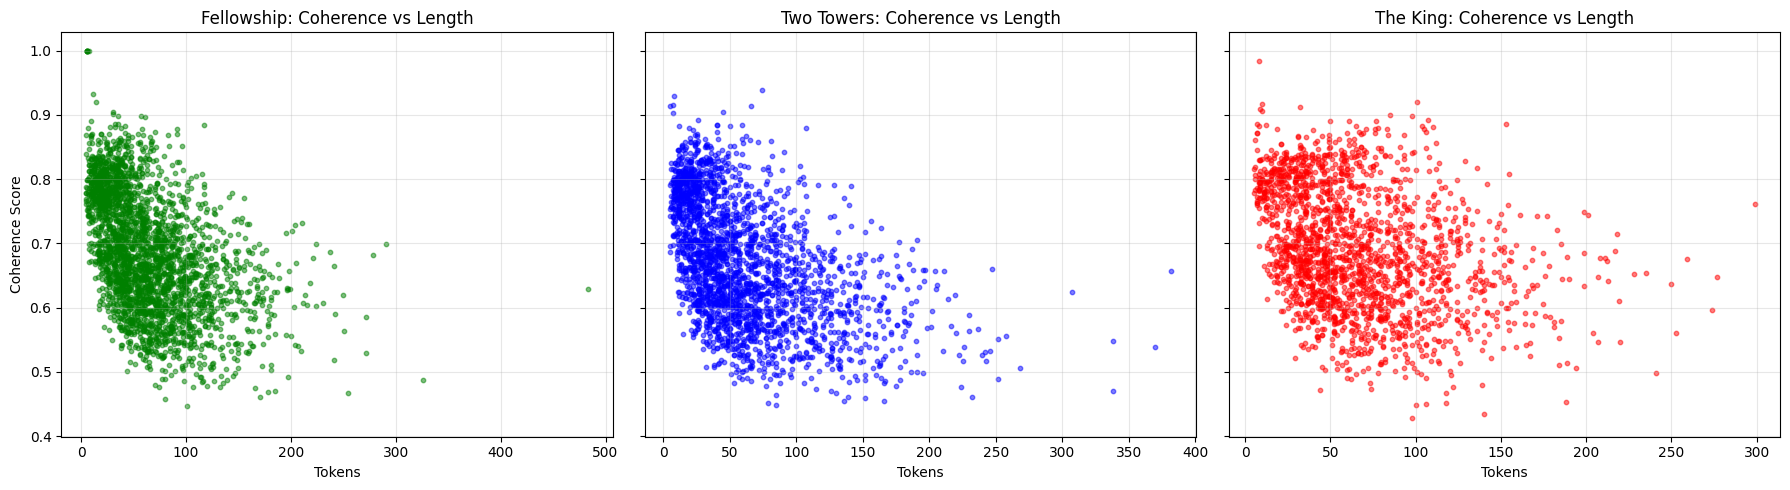

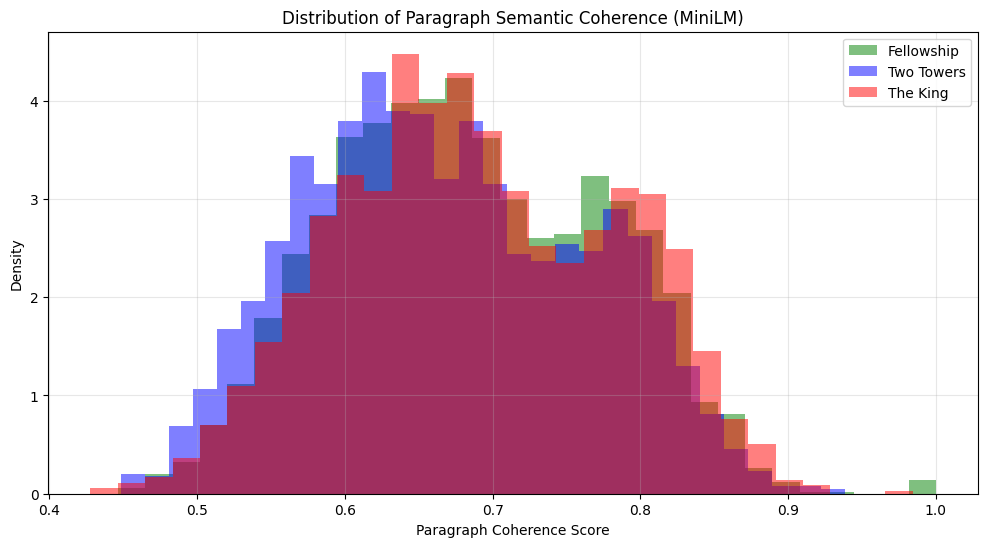

In [3]:
# 1. SCATTER PLOTS (Length vs Coherence)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Fellowship
axes[0].scatter(f_lengths, f_scores, alpha=0.5, color='green', s=10)
axes[0].set_title("Fellowship: Coherence vs Length")
axes[0].set_xlabel("Tokens")
axes[0].set_ylabel("Coherence Score")
axes[0].grid(True, alpha=0.3)

# Two Towers
axes[1].scatter(t_lengths, t_scores, alpha=0.5, color='blue', s=10)
axes[1].set_title("Two Towers: Coherence vs Length")
axes[1].set_xlabel("Tokens")
axes[1].grid(True, alpha=0.3)

# The King
axes[2].scatter(k_lengths, k_scores, alpha=0.5, color='red', s=10)
axes[2].set_title("The King: Coherence vs Length")
axes[2].set_xlabel("Tokens")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. HISTOGRAMS (Distribution Comparison)
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(f_scores, bins=30, alpha=0.5, label='Fellowship', density=True, color='green')
ax.hist(t_scores, bins=30, alpha=0.5, label='Two Towers', density=True, color='blue')
ax.hist(k_scores, bins=30, alpha=0.5, label='The King', density=True, color='red')

ax.set_xlabel('Paragraph Coherence Score')
ax.set_ylabel('Density')
ax.set_title('Distribution of Paragraph Semantic Coherence (MiniLM)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

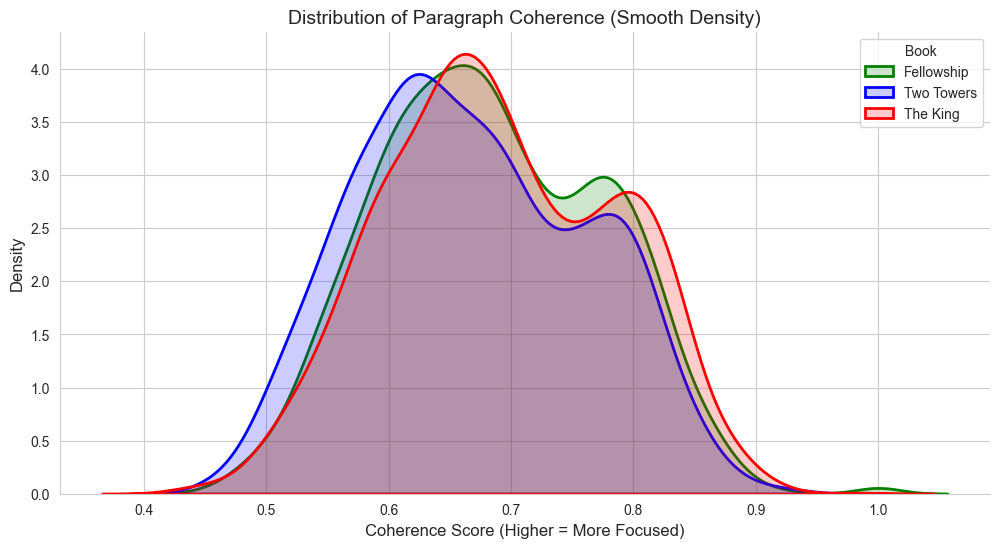

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a nice style
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12, 6))

# Plot smooth curves (KDE) with shading
# 'fill=True' fills the area under the curve
# 'alpha' controls transparency
sns.kdeplot(f_scores, fill=True, color='green', label='Fellowship', alpha=0.2, linewidth=2, ax=ax)
sns.kdeplot(t_scores, fill=True, color='blue', label='Two Towers', alpha=0.2, linewidth=2, ax=ax)
sns.kdeplot(k_scores, fill=True, color='red', label='The King', alpha=0.2, linewidth=2, ax=ax)

ax.set_title('Distribution of Paragraph Coherence (Smooth Density)', fontsize=14)
ax.set_xlabel('Coherence Score (Higher = More Focused)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.legend(title='Book')

# Remove the top and right spines for a cleaner look
sns.despine()

plt.show()

C:\Users\vlads\AppData\Local\Temp\ipykernel_12696\3994774806.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(data, patch_artist=True, labels=labels, medianprops=dict(color="black"))


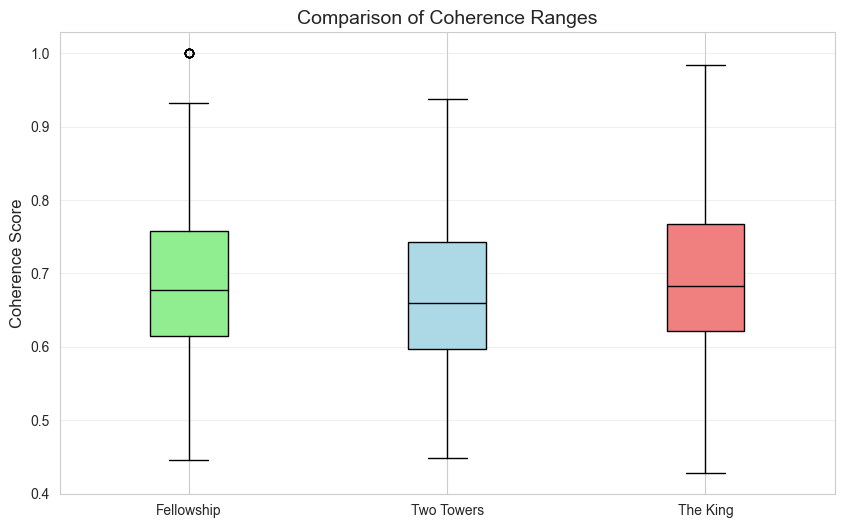

In [6]:
# Prepare data for boxplot
data = [f_scores, t_scores, k_scores]
labels = ['Fellowship', 'Two Towers', 'The King']
colors = ['lightgreen', 'lightblue', 'lightcoral']

fig, ax = plt.subplots(figsize=(10, 6))

# Create the boxplot
bplot = ax.boxplot(data, patch_artist=True, labels=labels, medianprops=dict(color="black"))

# Color code the boxes
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

ax.set_title('Comparison of Coherence Ranges', fontsize=14)
ax.set_ylabel('Coherence Score', fontsize=12)
ax.grid(True, axis='y', alpha=0.3)

plt.show()

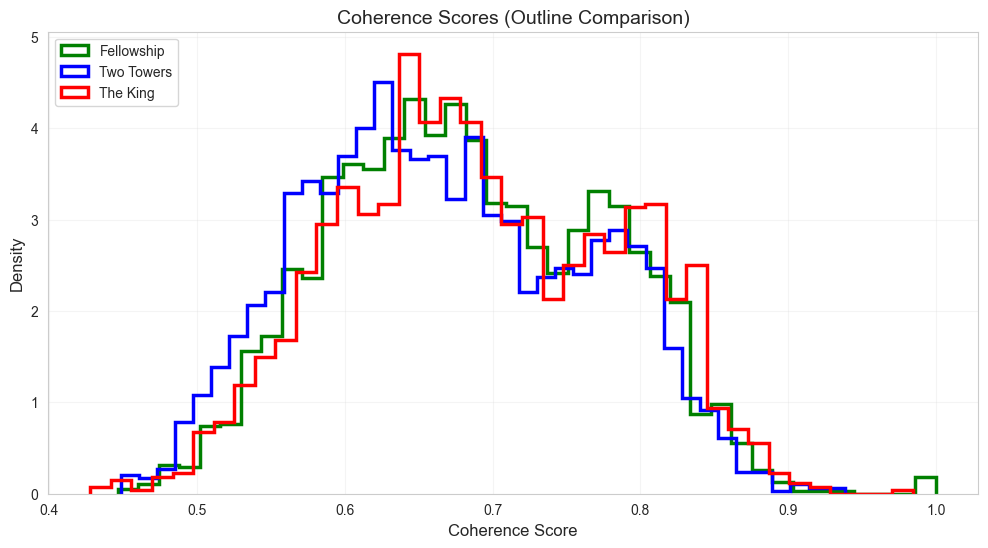

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))

# histtype='step' draws lines instead of bars
# linewidth makes them thick and visible
ax.hist(f_scores, bins=40, density=True, histtype='step', linewidth=2.5, color='green', label='Fellowship')
ax.hist(t_scores, bins=40, density=True, histtype='step', linewidth=2.5, color='blue', label='Two Towers')
ax.hist(k_scores, bins=40, density=True, histtype='step', linewidth=2.5, color='red', label='The King')

ax.set_title('Coherence Scores (Outline Comparison)', fontsize=14)
ax.set_xlabel('Coherence Score', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.2)

plt.show()

## Memory Cleanup

If you're running low on memory, run this cell to free up RAM by deleting large variables and clearing the model cache.

In [4]:
# Clean up memory
del fellowship_text, towers_text, king_text
del fellowship_paras, towers_paras, king_paras
del f_scores, f_lengths, t_scores, t_lengths, k_scores, k_lengths
del model
gc.collect()
print("Memory cleared.")

Memory cleared.
